# Feed the input dataset into LSTM
## Selected Features: Eye gaze, Head pose, Au (EHA)

In [1]:
import numpy as np
import pandas as pd
import pickle
from datetime import datetime

from keras.models import Sequential, Input
from keras.layers import *
# from keras.layers import Attention
from keras.optimizers import *
import matplotlib.pyplot as plt
from livelossplot.tf_keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, fbeta_score, auc, roc_auc_score
from sklearn.model_selection import KFold

import seaborn as sns


%matplotlib inline
# %matplotlib notebook

Using TensorFlow backend.


In [2]:
# # Load selected features
path = ('C:/Users/hasegawa-lab-pc/OneDrive - Japan Advanced Institute of Science and Technology/Documents/Exp_Shofi/Preprocess and Statistical Analysis/extracted/')
# # Eye Features
# with open(path+'eye.pkl','rb') as f:
#     X_train_eye1, Y_train_eye1, X_val_eye1, Y_val_eye1, X_test_eye1, Y_test_eye1= pickle.load(f)

# # Head Pose
# with open(path+'head.pkl','rb') as f:
#     X_train_head, Y_train_head,X_val_head, Y_val_head,X_test_head, Y_test_head = pickle.load(f)

# # AUs
# with open(path+'au.pkl','rb') as f:
#     X_train_au, Y_train_au, X_val_au, Y_val_au, X_test_au, Y_test_au = pickle.load(f)

# 10 timesteps (averaged every 30 frames)
with open(path+'daisee_EHA.pkl','rb') as f:
    X_train_eye, X_val_eye, X_test_eye, X_train_head, X_val_head, X_test_head, X_train_au, X_val_au, X_test_au, Y_train_eye, Y_val_eye,  Y_test_eye= pickle.load(f)

# No feature selection (10 timesteps (averaged every 30 frames))
with open(path+'daisee_329dims_10timesteps.pkl','rb') as f:
    X_train_all, X_val_all, X_test_all, X_train_all_scalled, X_val_all_scalled, X_test_all_scalled,Y_train, Y_val, Y_test = pickle.load(f)

In [6]:
# stack all features
X_train = np.dstack((X_train_eye,X_train_head,X_train_au))
X_val = np.dstack((X_val_eye,X_val_head,X_val_au))
X_test = np.dstack ((X_test_eye,X_test_head,X_test_au))
print(X_train.shape,X_val.shape,X_test.shape)

(5467, 10, 23) (1703, 10, 23) (1782, 10, 23)


In [7]:
# Scalling EHA features input
tic = datetime.now()

scaler = MinMaxScaler(feature_range=(0,1))
X_train_scalled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

X_val_scalled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

X_test_scalled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

time = datetime.now() - tic
print('Processing time {}'.format(time))
print(X_train_scalled.shape,X_val_scalled.shape,X_test_scalled.shape)

Processing time 0:00:00.013963
(5467, 10, 23) (1703, 10, 23) (1782, 10, 23)


In [8]:
# To Categorical
Y_train = Y_train_eye
Y_train_cat = to_categorical(Y_train)
Y_val = Y_val_eye
Y_val_cat = to_categorical(Y_val)
Y_test = Y_test_eye
Y_test_cat = to_categorical(Y_test)
# print('Y train',Y_train_cat)


In [11]:
def vanilaLSTM(X):
    model = Sequential()
    model.add(LSTM(100, input_shape=(X.shape[1],X.shape[2]))) #use average data
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))
    model.name='vanilaLSTM'
    # print(model.summary())
    return model

def stackedLSTM(X):
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X.shape[1],X.shape[2])))
    # model.add(Dropout(0.1))
    model.add(LSTM(75, activation='relu'))
    # model.add(Dropout(0.1))
    model.add(Dense(4, activation='softmax'))
    model.name='stackedLSTM'
    print(model.summary())
    return model

def biLSTM(X):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(X.shape[1],X.shape[2])))
    # model.add(Dropout(0.1))
    model.add(Dense(4, activation='softmax'))
    model.name='biLSTM'
#     print(model.summary())
    return model

def biLSTM_en(X):
    model = Sequential()
    model.add(InputLayer(input_shape=((X.shape[1],X.shape[2]))))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50)))
    model.add(Dropout(0.2))
    # modelD.add(GlobalAveragePooling1D())
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(4, activation='softmax'))
    model.name='biLSTM_en'
    print(model.summary())
    return model

In [13]:
# Instantiate the model
# vanilaLSTM_model = vanilaLSTM(X_train)
# vanilaLSTM_model_feat = vanilaLSTM(X_train_eye) #also for head
# vanilaLSTM_model_au = vanilaLSTM(X_train_au)

stackedLSTM_model = stackedLSTM(X_train)
# stackedLSTM_model_feat = stackedLSTM(X_train_eye)
# stackedLSTM_model_au = stackedLSTM(X_train_au)

# biLSTM_model = biLSTM(X_train)
# biLSTM_model_feat = biLSTM(X_train_eye)
# biLSTM_model_au = biLSTM(X_train_au)

biLSTM_en_model = biLSTM_en(X_train)
# biLSTM_en_model_feat = biLSTM_en(X_train_eye)
# biLSTM_en_model_au = biLSTM_en(X_train_au)

# vanilaLSTM_model_all = vanilaLSTM(X_train_all_scalled)
# stackedLSTM_model_all = stackedLSTM(X_train_all_scalled)
# biLSTM_model_all = biLSTM(X_train_all_scalled)
# biLSTM_en_model_all = biLSTM_en(X_train_all_scalled)

Model: "stackedLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 10, 100)           49600     
_________________________________________________________________
lstm_42 (LSTM)               (None, 75)                52800     
_________________________________________________________________
dense_49 (Dense)             (None, 4)                 304       
Total params: 102,704
Trainable params: 102,704
Non-trainable params: 0
_________________________________________________________________
None
Model: "biLSTM_en"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 10, 16)            384       
_________________________________________________________________
batch_normalization_9 (Batch (None, 10, 16)            64        
_________________________

In [9]:
# Compile, fit, and evaluate the model

def compile_train(model,Xtrain,Ytrain,Xval,Yval):
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy',tf.keras.metrics.AUC()]) #

    filepath = 'weights/' + model.name + '.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2,
                                 save_weights_only=True, save_best_only=True,
                                 mode='auto')
    
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_lr=0.00001,mode='auto')

    es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20)
    history = model.fit(Xtrain,Ytrain, epochs=500, verbose=1,
                        callbacks = [PlotLossesCallback(), checkpoint, es],
                        batch_size = 32,
                        # validation_split=0.2,
                        validation_data = (Xval,Yval), 
                        shuffle=False,
                        class_weight = 'balanced'
                       ) 
    return history


def evaluate_error(trainedmodel,Xtest,Ytest): # X_test, Y_test,
    pred = trainedmodel.predict(Xtest, batch_size=32)
    pred = np.argmax(pred, axis=1)
    error = np.sum(np.not_equal(pred, Ytest)) / Ytest.shape[0] #error rate
    mse = mean_squared_error(Ytest,pred)
    acc = accuracy_score(Ytest, pred) #accuracy
    f1 = f1_score(Ytest, pred, average='macro')
    fbeta = fbeta_score(Ytest, pred, average='macro', beta=4)
    auc = roc_auc_score(Ytest, trainedmodel.predict_proba(Xtest), average='macro', multi_class='ovr')
    rc = recall_score(Ytest, pred, average=None) #Recall score
    ps = precision_score(Ytest, pred, average=None) #Precision
    print('|'+ trainedmodel.name + '|\n Error rate =', error,
        '\n MSE = ',mse,
        '\n Accuracy = ',acc,
        '\n AUC = ', auc,
        '\n F1-score = ',f1,
        '\n Fbeta = ',fbeta
        )

        #  Plotting confusion matrix
    cm = confusion_matrix(Ytest, pred) #confusion matrix
    cm = pd.DataFrame(cm,range(4),range(4))

    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5)
    sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    return 

# Train 


### 4. BiLSTM Ensamble

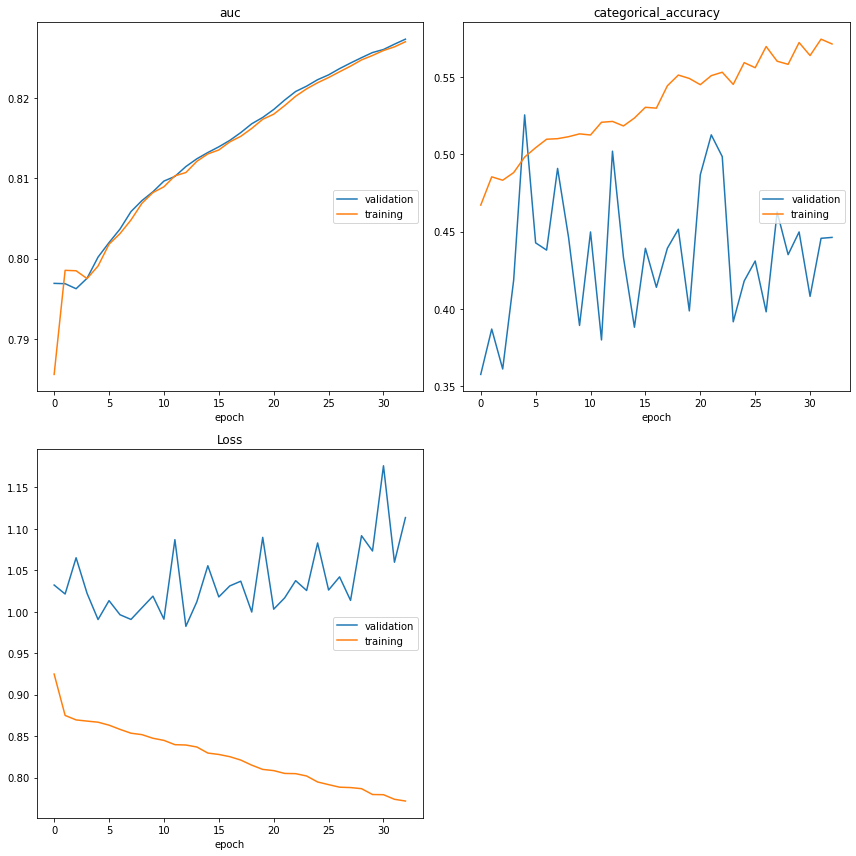

auc
	validation       	 (min:    0.796, max:    0.827, cur:    0.827)
	training         	 (min:    0.786, max:    0.827, cur:    0.827)
categorical_accuracy
	validation       	 (min:    0.358, max:    0.526, cur:    0.446)
	training         	 (min:    0.467, max:    0.575, cur:    0.571)
Loss
	validation       	 (min:    0.982, max:    1.176, cur:    1.114)
	training         	 (min:    0.772, max:    0.925, cur:    0.772)
Training time:0:01:30.412552
1782/1782 [==============================] - 0s 109us/step
Accuracy on Test set: 45.57%


In [10]:
# No feature selection  (329 dimensions)
tic = datetime.now()

compile_train(biLSTM_en_model_all, X_train_all_scalled, Y_train_cat, X_val_all_scalled, Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model_all.evaluate(X_test_all_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

|biLSTM_en|
 Error rate = 0.5443322109988776 
 MSE =  0.6554433221099888 
 Accuracy =  0.4556677890011223 
 AUC =  0.5698091103425433 
 F1-score =  0.26213090347660667 
 Fbeta =  0.26132706655903637
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


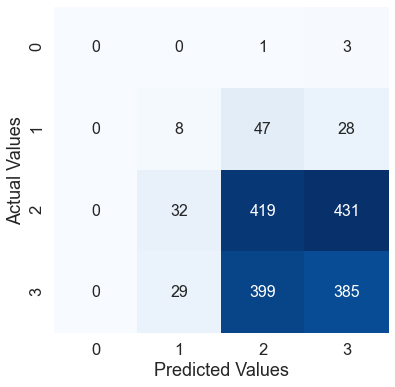

In [11]:
print(evaluate_error(biLSTM_en_model_all,X_test_all_scalled, Y_test))

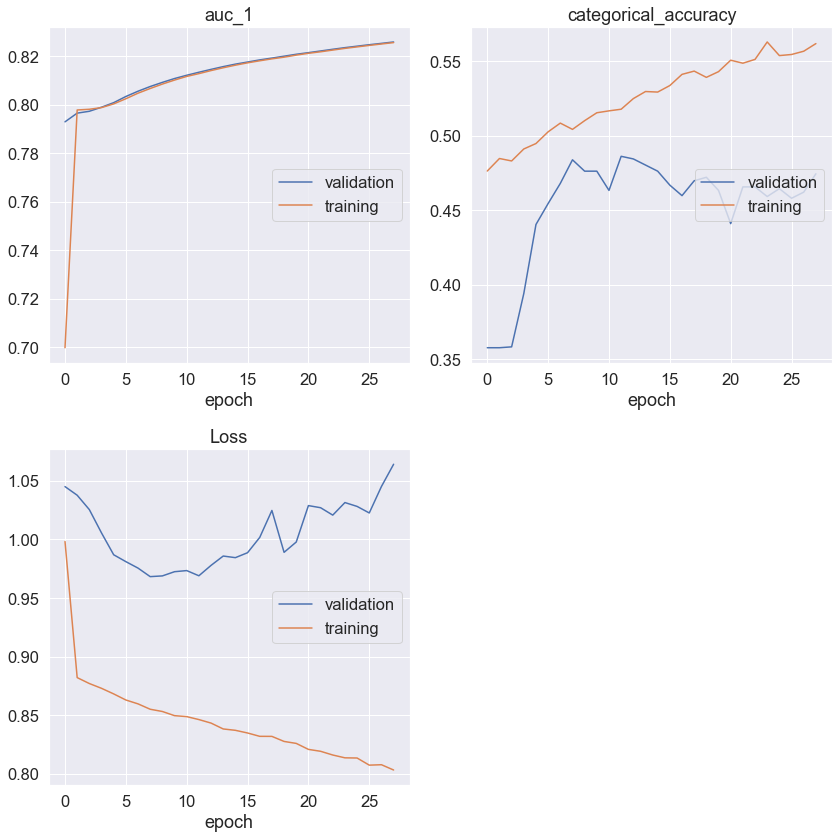

auc_1
	validation       	 (min:    0.793, max:    0.826, cur:    0.826)
	training         	 (min:    0.700, max:    0.826, cur:    0.826)
categorical_accuracy
	validation       	 (min:    0.358, max:    0.486, cur:    0.474)
	training         	 (min:    0.476, max:    0.563, cur:    0.562)
Loss
	validation       	 (min:    0.968, max:    1.064, cur:    1.064)
	training         	 (min:    0.803, max:    0.998, cur:    0.803)
Training time:0:01:18.794155
1782/1782 [==============================] - 0s 105us/step
Accuracy on Test set: 45.68%
|biLSTM_en|
 Error rate = 0.5432098765432098 
 MSE =  0.6986531986531986 
 Accuracy =  0.4567901234567901 
 AUC =  0.5818773681322722 
 F1-score =  0.2843663309622488 
 Fbeta =  0.282367269596437
None


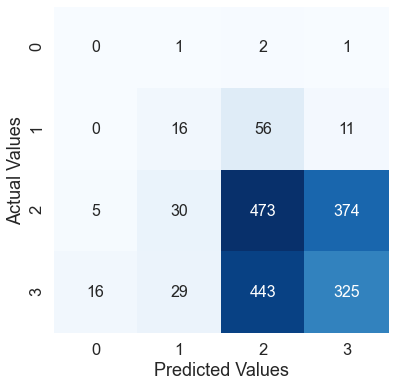

In [12]:
# EHA (scalled)
tic = datetime.now()

compile_train(biLSTM_en_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_en_model,X_test_scalled,Y_test))

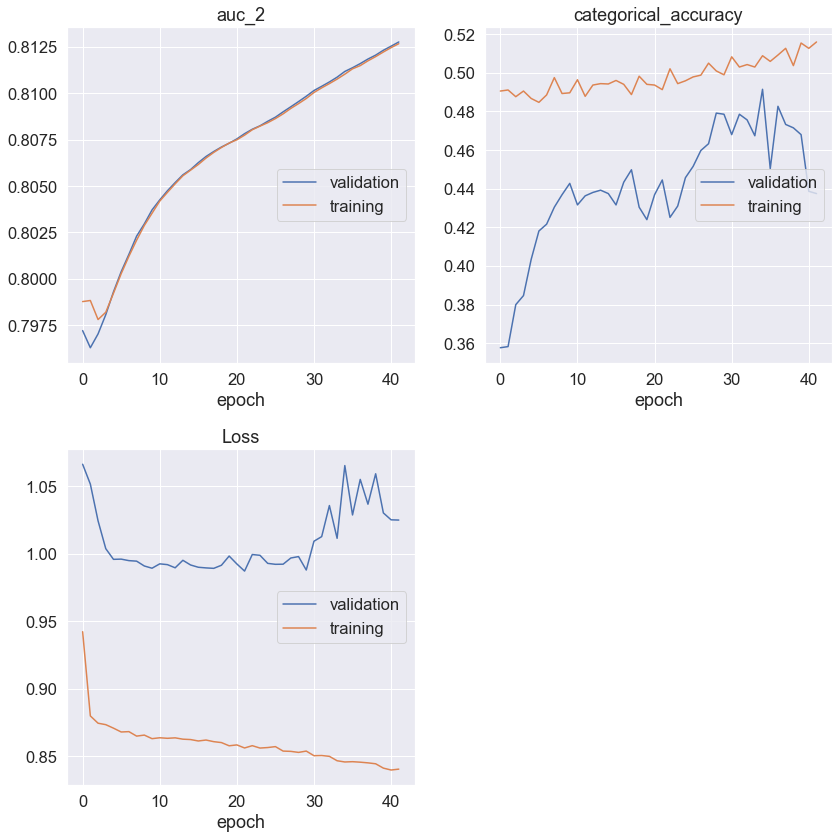

auc_2
	validation       	 (min:    0.796, max:    0.813, cur:    0.813)
	training         	 (min:    0.798, max:    0.813, cur:    0.813)
categorical_accuracy
	validation       	 (min:    0.358, max:    0.491, cur:    0.437)
	training         	 (min:    0.485, max:    0.516, cur:    0.516)
Loss
	validation       	 (min:    0.987, max:    1.066, cur:    1.025)
	training         	 (min:    0.840, max:    0.942, cur:    0.840)
Training time:0:01:56.830789
1782/1782 [==============================] - 0s 104us/step
Accuracy on Test set: 44.56%
|biLSTM_en|
 Error rate = 0.5544332210998878 
 MSE =  0.6402918069584737 
 Accuracy =  0.44556677890011226 
 AUC =  0.5107628568756353 
 F1-score =  0.2594035577971647 
 Fbeta =  0.2575481140610005
None


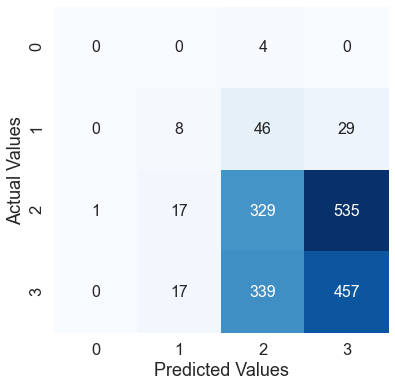

In [13]:
# Eye Gaze only
tic = datetime.now()

compile_train(biLSTM_en_model_feat,X_train_eye,Y_train_cat,X_val_eye,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model_feat.evaluate(X_test_eye,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_en_model_feat,X_test_eye,Y_test))

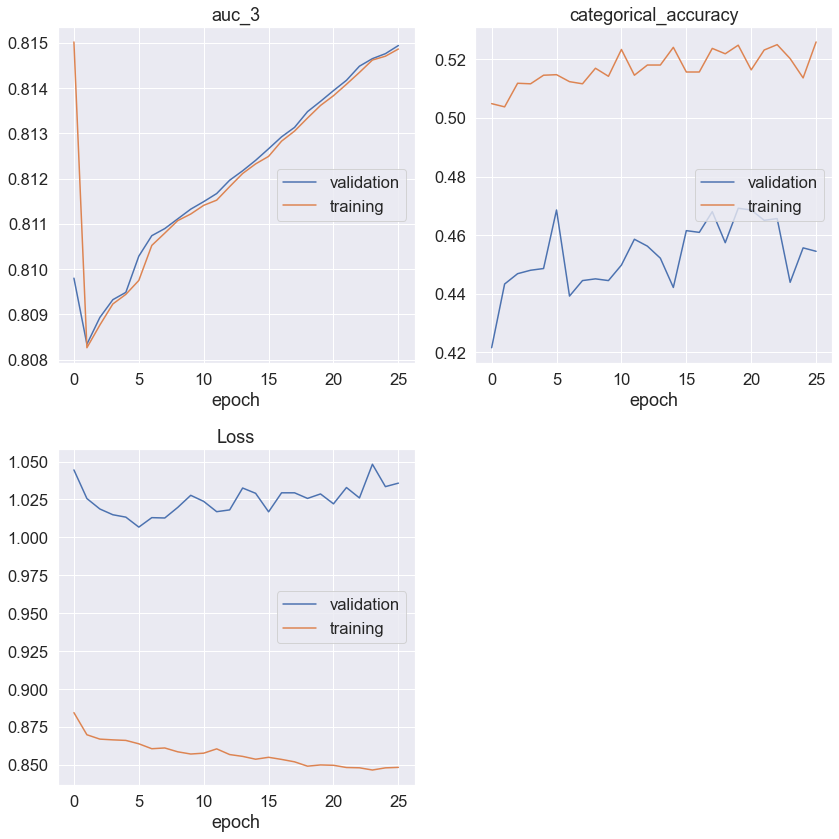

auc_3
	validation       	 (min:    0.808, max:    0.815, cur:    0.815)
	training         	 (min:    0.808, max:    0.815, cur:    0.815)
categorical_accuracy
	validation       	 (min:    0.422, max:    0.469, cur:    0.454)
	training         	 (min:    0.504, max:    0.526, cur:    0.526)
Loss
	validation       	 (min:    1.007, max:    1.048, cur:    1.036)
	training         	 (min:    0.847, max:    0.884, cur:    0.848)
Training time:0:01:22.871040
1782/1782 [==============================] - 0s 103us/step
Accuracy on Test set: 50.73%
|biLSTM_en|
 Error rate = 0.49270482603815935 
 MSE =  0.5791245791245792 
 Accuracy =  0.5072951739618407 
 AUC =  0.578198101534668 
 F1-score =  0.2571069202630365 
 Fbeta =  0.267271251069259
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

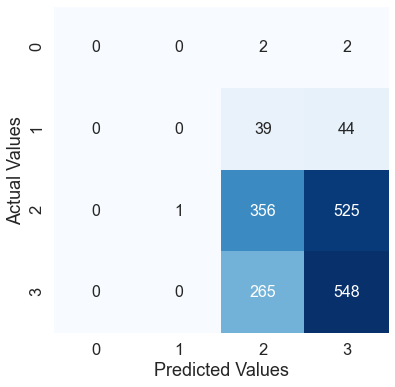

In [14]:
# Head Pose only
tic = datetime.now()

compile_train(biLSTM_en_model_feat,X_train_head,Y_train_cat,X_val_head,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model_feat.evaluate(X_test_head,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_en_model_feat,X_test_head,Y_test))

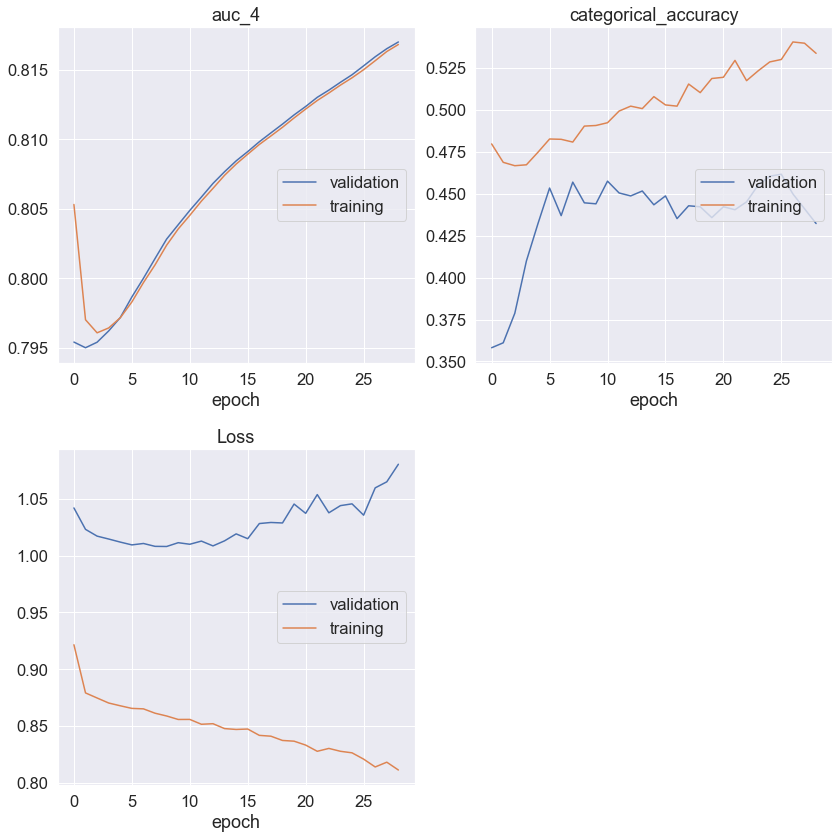

auc_4
	validation       	 (min:    0.795, max:    0.817, cur:    0.817)
	training         	 (min:    0.796, max:    0.817, cur:    0.817)
categorical_accuracy
	validation       	 (min:    0.358, max:    0.462, cur:    0.432)
	training         	 (min:    0.467, max:    0.540, cur:    0.534)
Loss
	validation       	 (min:    1.008, max:    1.080, cur:    1.080)
	training         	 (min:    0.811, max:    0.921, cur:    0.811)
Training time:0:01:21.278078
1782/1782 [==============================] - 0s 98us/step
Accuracy on Test set: 47.92%
|biLSTM_en|
 Error rate = 0.5207631874298541 
 MSE =  0.6257014590347924 
 Accuracy =  0.4792368125701459 
 AUC =  0.5291047666773706 
 F1-score =  0.24723872615171547 
 Fbeta =  0.2584181385632771
None


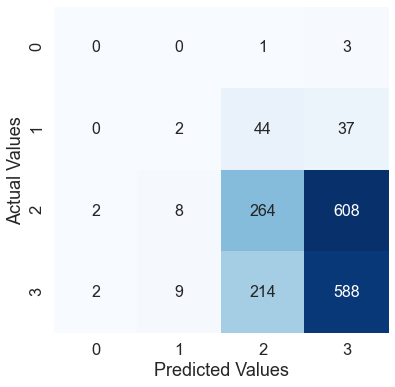

In [15]:
# AU only
tic = datetime.now()

compile_train(biLSTM_en_model_au,X_train_au,Y_train_cat,X_val_au,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model_au.evaluate(X_test_au,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_en_model_au,X_test_au,Y_test))

## 1. Vanila LSTM

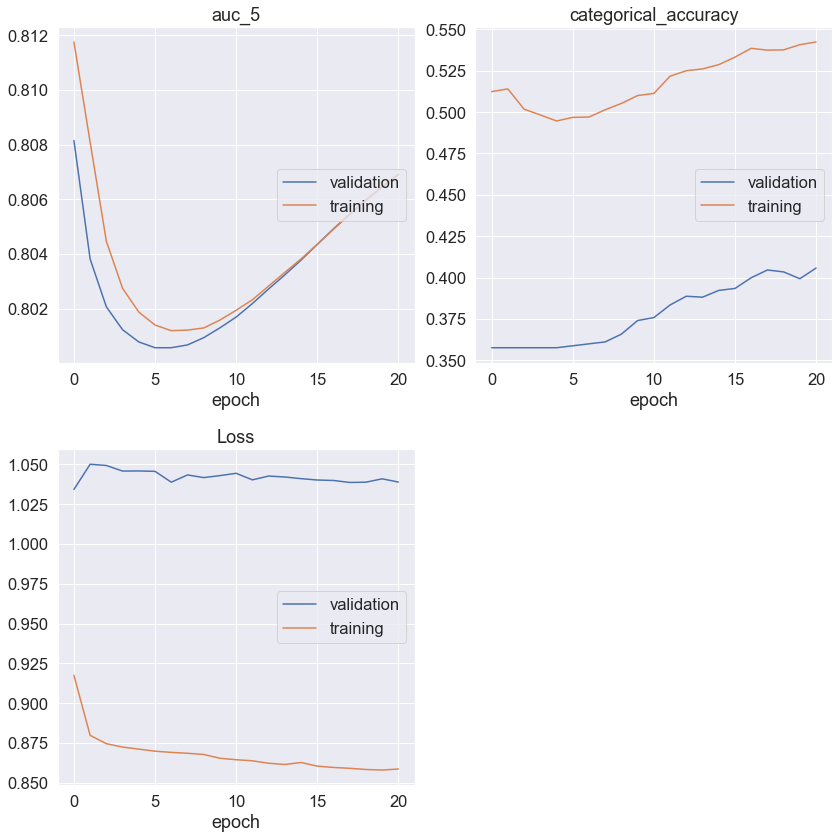

auc_5
	validation       	 (min:    0.801, max:    0.808, cur:    0.807)
	training         	 (min:    0.801, max:    0.812, cur:    0.807)
categorical_accuracy
	validation       	 (min:    0.358, max:    0.406, cur:    0.406)
	training         	 (min:    0.495, max:    0.542, cur:    0.542)
Loss
	validation       	 (min:    1.034, max:    1.050, cur:    1.039)
	training         	 (min:    0.858, max:    0.917, cur:    0.859)
Training time:0:00:35.909021
1782/1782 [==============================] - 0s 70us/step
Accuracy on Test set: 47.42%
|vanilaLSTM|
 Error rate = 0.5258136924803591 
 MSE =  0.67003367003367 
 Accuracy =  0.47418630751964086 
 AUC =  0.5744056723915065 
 F1-score =  0.2083707957629611 
 Fbeta =  0.24715900351267503
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

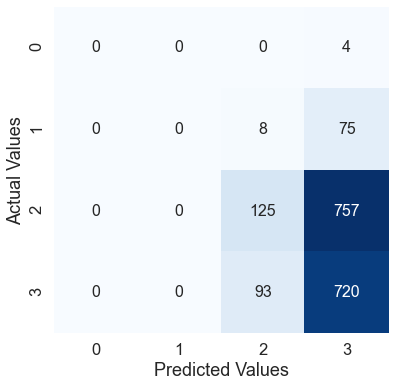

In [16]:
# No feature selection  (329 dimensions)
tic = datetime.now()

compile_train(vanilaLSTM_model_all,X_train_all_scalled,Y_train_cat,X_val_all_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model_all.evaluate(X_test_all_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(vanilaLSTM_model_all,X_test_all_scalled, Y_test))


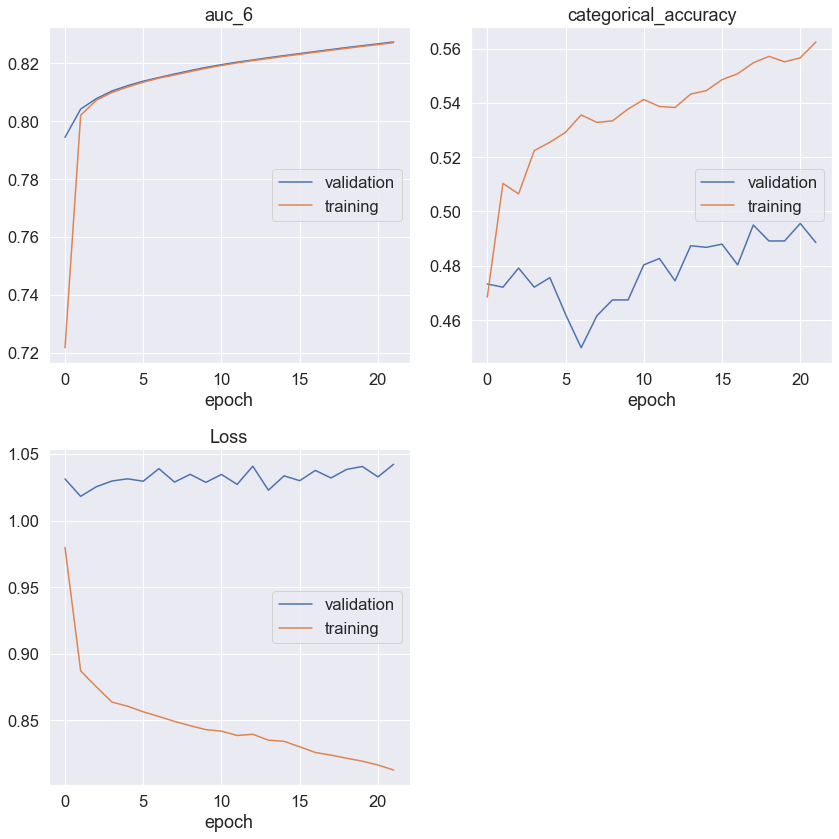

auc_6
	validation       	 (min:    0.794, max:    0.827, cur:    0.827)
	training         	 (min:    0.722, max:    0.827, cur:    0.827)
categorical_accuracy
	validation       	 (min:    0.450, max:    0.496, cur:    0.489)
	training         	 (min:    0.468, max:    0.562, cur:    0.562)
Loss
	validation       	 (min:    1.018, max:    1.042, cur:    1.042)
	training         	 (min:    0.813, max:    0.980, cur:    0.813)
Training time:0:00:35.945838
1782/1782 [==============================] - 0s 62us/step
Accuracy on Test set: 48.71%
|vanilaLSTM|
 Error rate = 0.5129068462401796 
 MSE =  0.5993265993265994 
 Accuracy =  0.48709315375982043 
 AUC =  0.4736483226570567 
 F1-score =  0.24951993404079897 
 Fbeta =  0.2548323181798531
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

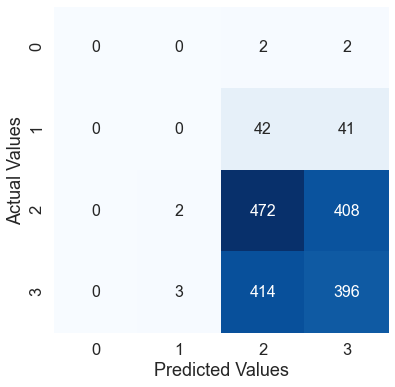

In [17]:
# # ALL features (non-scalled)
# tic = datetime.now()

# compile_train(vanilaLSTM_model,X_train,Y_train_cat,X_val,Y_val_cat) 
# time = datetime.now() - tic
# print("Training time:{}".format(time))

# scores = vanilaLSTM_model.evaluate(X_test,Y_test_cat)
# print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

# print(evaluate_error(vanilaLSTM_model,X_test, Y_test))


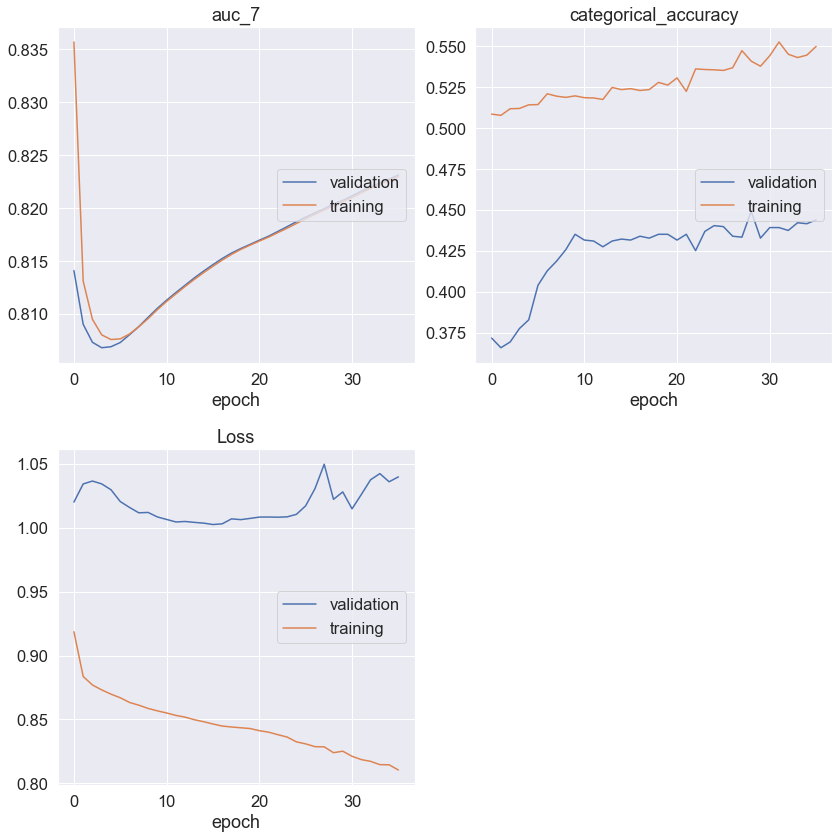

auc_7
	validation       	 (min:    0.807, max:    0.823, cur:    0.823)
	training         	 (min:    0.808, max:    0.836, cur:    0.823)
categorical_accuracy
	validation       	 (min:    0.366, max:    0.449, cur:    0.444)
	training         	 (min:    0.508, max:    0.553, cur:    0.550)
Loss
	validation       	 (min:    1.003, max:    1.050, cur:    1.040)
	training         	 (min:    0.810, max:    0.919, cur:    0.810)
Training time:0:01:04.600761
1782/1782 [==============================] - 0s 59us/step
Accuracy on Test set: 46.69%
|vanilaLSTM|
 Error rate = 0.5331088664421998 
 MSE =  0.6195286195286195 
 Accuracy =  0.4668911335578002 
 AUC =  0.49513815767544345 
 F1-score =  0.23851927747843324 
 Fbeta =  0.2491412056249499
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

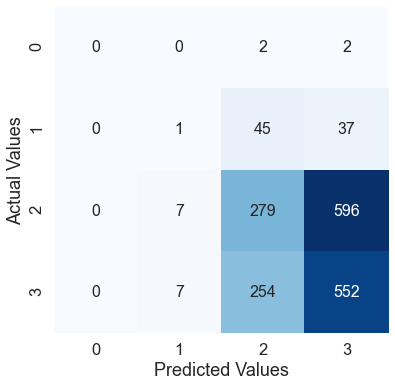

In [18]:
# ALL features (scalled)
tic = datetime.now()

compile_train(vanilaLSTM_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(vanilaLSTM_model,X_test_scalled,Y_test))

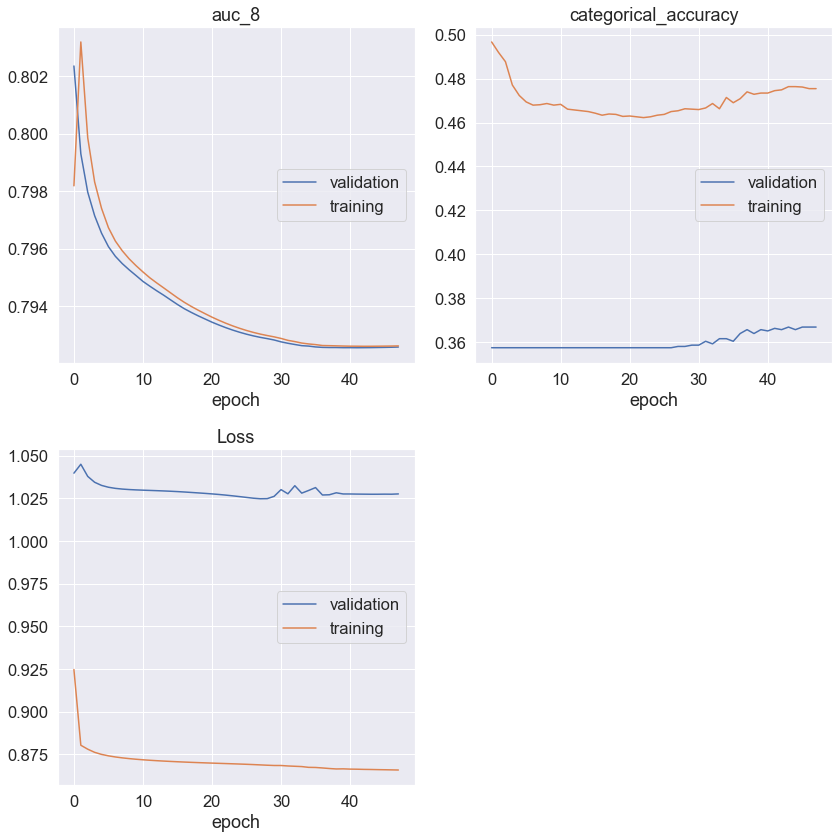

auc_8
	validation       	 (min:    0.793, max:    0.802, cur:    0.793)
	training         	 (min:    0.793, max:    0.803, cur:    0.793)
categorical_accuracy
	validation       	 (min:    0.358, max:    0.367, cur:    0.367)
	training         	 (min:    0.462, max:    0.497, cur:    0.475)
Loss
	validation       	 (min:    1.025, max:    1.045, cur:    1.028)
	training         	 (min:    0.866, max:    0.925, cur:    0.866)
Training time:0:01:17.837528
1782/1782 [==============================] - 0s 61us/step
Accuracy on Test set: 45.96%
|vanilaLSTM|
 Error rate = 0.5404040404040404 
 MSE =  0.6902356902356902 
 Accuracy =  0.4595959595959596 
 AUC =  0.4361599274500054 
 F1-score =  0.161573933137765 
 Fbeta =  0.23567369321937506
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

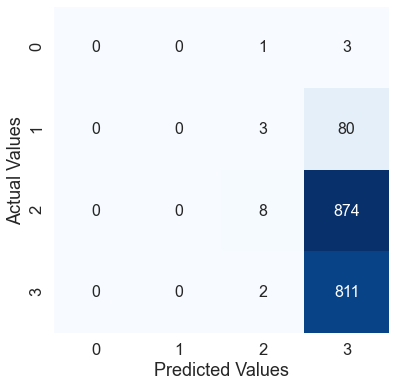

In [19]:
# ALL features (Eye Gaze only)
tic = datetime.now()

compile_train(vanilaLSTM_model_feat,X_train_eye,Y_train_cat,X_val_eye,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model_feat.evaluate(X_test_eye,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(vanilaLSTM_model_feat,X_test_eye,Y_test))

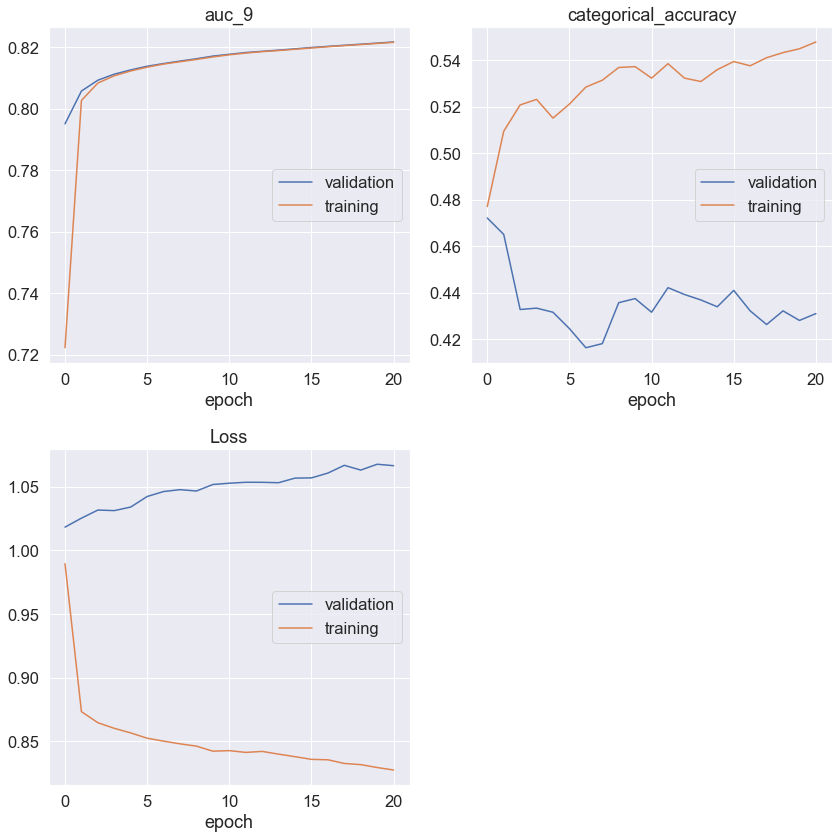

auc_9
	validation       	 (min:    0.795, max:    0.822, cur:    0.822)
	training         	 (min:    0.722, max:    0.822, cur:    0.822)
categorical_accuracy
	validation       	 (min:    0.416, max:    0.472, cur:    0.431)
	training         	 (min:    0.477, max:    0.548, cur:    0.548)
Loss
	validation       	 (min:    1.018, max:    1.068, cur:    1.067)
	training         	 (min:    0.827, max:    0.990, cur:    0.827)
Training time:0:00:38.034482
1782/1782 [==============================] - 0s 59us/step
Accuracy on Test set: 45.12%
|vanilaLSTM|
 Error rate = 0.5488215488215489 
 MSE =  0.6481481481481481 
 Accuracy =  0.4511784511784512 
 AUC =  0.4916447605926356 
 F1-score =  0.22993326214628937 
 Fbeta =  0.23767600428781427
None


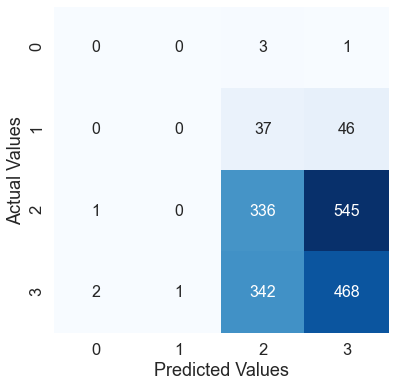

In [20]:
# ALL features (Head Pose only)
tic = datetime.now()

compile_train(vanilaLSTM_model_feat,X_train_head,Y_train_cat,X_val_head,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model_feat.evaluate(X_test_head,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(vanilaLSTM_model_feat,X_test_head,Y_test))

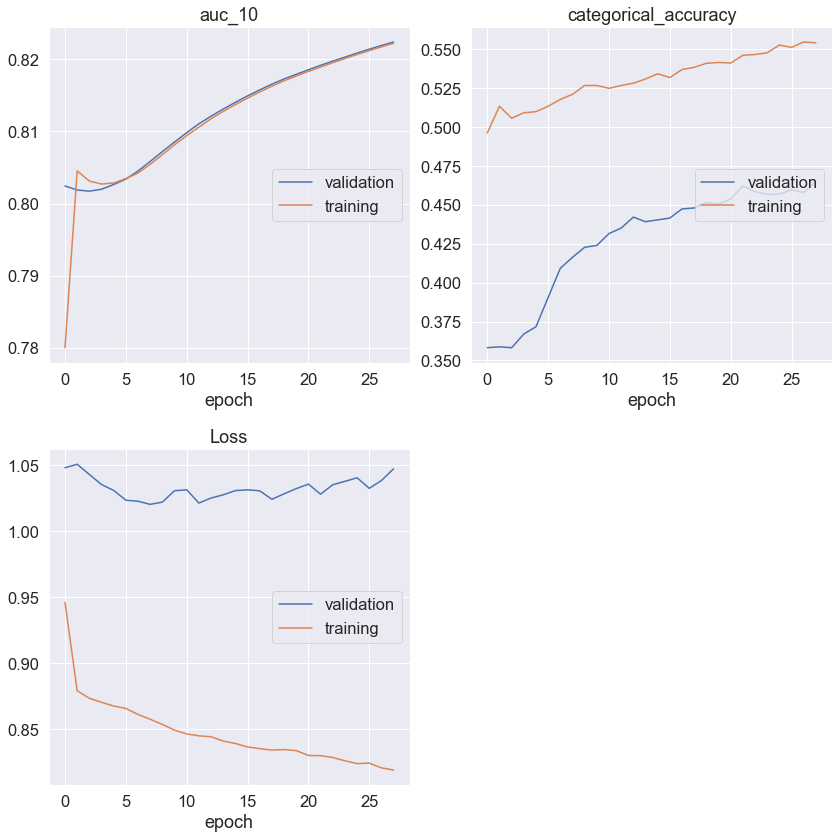

auc_10
	validation       	 (min:    0.802, max:    0.822, cur:    0.822)
	training         	 (min:    0.780, max:    0.822, cur:    0.822)
categorical_accuracy
	validation       	 (min:    0.358, max:    0.465, cur:    0.465)
	training         	 (min:    0.496, max:    0.555, cur:    0.554)
Loss
	validation       	 (min:    1.020, max:    1.051, cur:    1.047)
	training         	 (min:    0.819, max:    0.946, cur:    0.819)
Training time:0:00:46.269847
1782/1782 [==============================] - 0s 62us/step
Accuracy on Test set: 48.15%
|vanilaLSTM|
 Error rate = 0.5185185185185185 
 MSE =  0.6066217732884399 
 Accuracy =  0.48148148148148145 
 AUC =  0.5510525247156606 
 F1-score =  0.24047450967209383 
 Fbeta =  0.2537581396105917
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

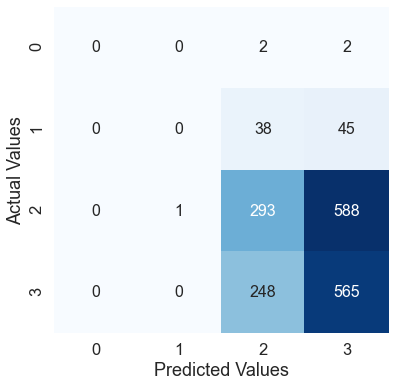

In [21]:
# ALL features (AU only)
tic = datetime.now()

compile_train(vanilaLSTM_model_au,X_train_au,Y_train_cat,X_val_au,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model_au.evaluate(X_test_au,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(vanilaLSTM_model_au,X_test_au,Y_test))

## 2. Stacked LSTM

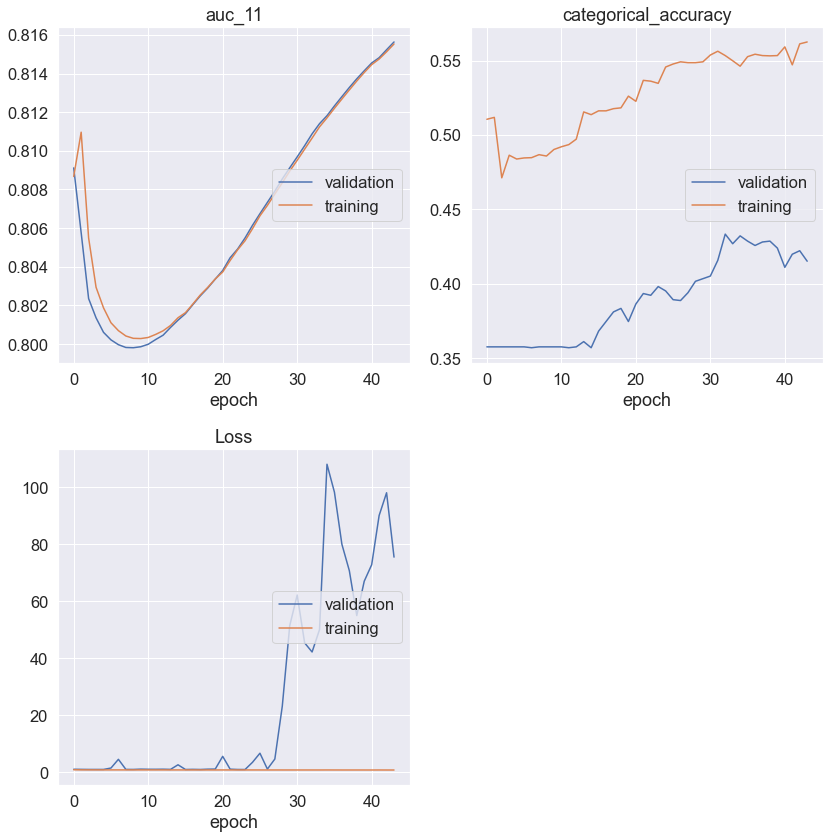

auc_11
	validation       	 (min:    0.800, max:    0.816, cur:    0.816)
	training         	 (min:    0.800, max:    0.816, cur:    0.816)
categorical_accuracy
	validation       	 (min:    0.357, max:    0.433, cur:    0.415)
	training         	 (min:    0.471, max:    0.562, cur:    0.562)
Loss
	validation       	 (min:    1.008, max:  108.007, cur:   75.458)
	training         	 (min:    0.835, max:    0.921, cur:    0.835)
Training time:0:01:56.203660
1782/1782 [==============================] - 0s 104us/step
Accuracy on Test set: 46.69%
|stackedLSTM|
 Error rate = 0.5331088664421998 
 MSE =  0.6481481481481481 
 Accuracy =  0.4668911335578002 
 AUC =  0.628993910574134 
 F1-score =  0.2123620402102371 
 Fbeta =  0.24678107528260548
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

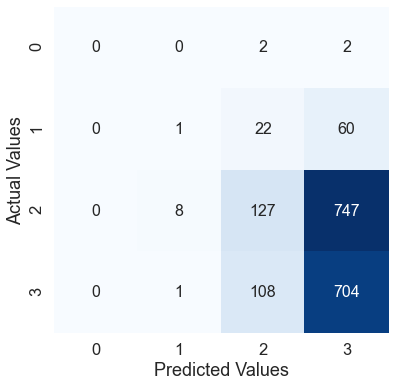

In [22]:
# ALL features  (329 dimensions)
tic = datetime.now()

compile_train(stackedLSTM_model_all,X_train_all_scalled,Y_train_cat,X_val_all_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model_all.evaluate(X_test_all_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(stackedLSTM_model_all,X_test_all_scalled, Y_test))

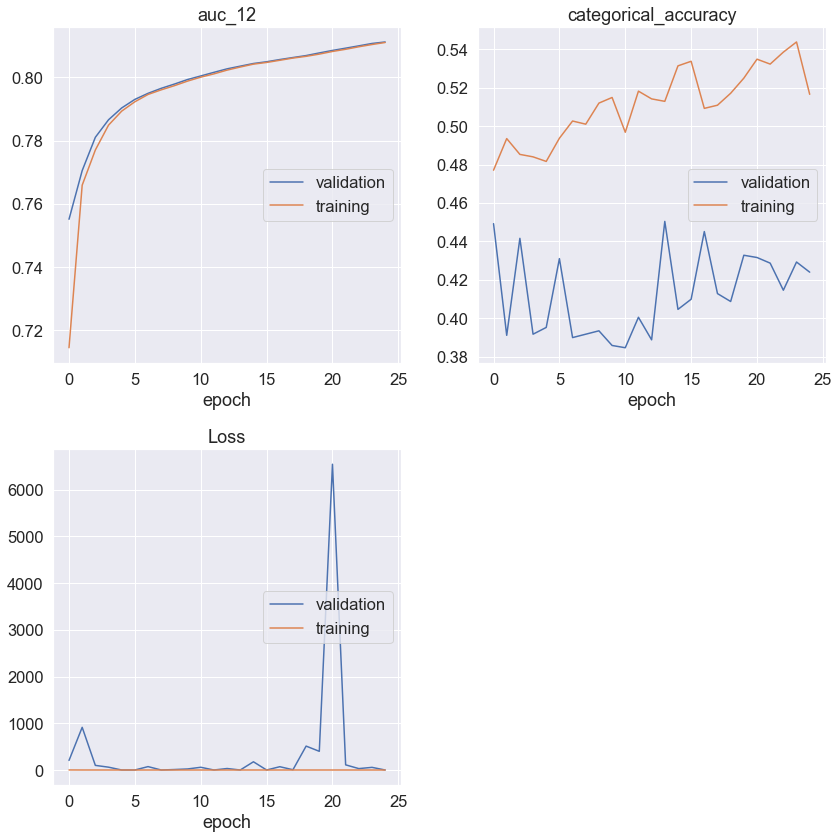

auc_12
	validation       	 (min:    0.755, max:    0.811, cur:    0.811)
	training         	 (min:    0.714, max:    0.811, cur:    0.811)
categorical_accuracy
	validation       	 (min:    0.385, max:    0.450, cur:    0.424)
	training         	 (min:    0.477, max:    0.544, cur:    0.517)
Loss
	validation       	 (min:    1.040, max: 6543.240, cur:    1.109)
	training         	 (min:    0.826, max:    2.126, cur:    0.835)
Training time:0:01:05.252907
1782/1782 [==============================] - 0s 95us/step
Accuracy on Test set: 48.60%
|stackedLSTM|
 Error rate = 0.5140291806958474 
 MSE =  0.6402918069584737 
 Accuracy =  0.48597081930415265 
 AUC =  0.4469318822060001 
 F1-score =  0.24244306879376606 
 Fbeta =  0.25599962590256753
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

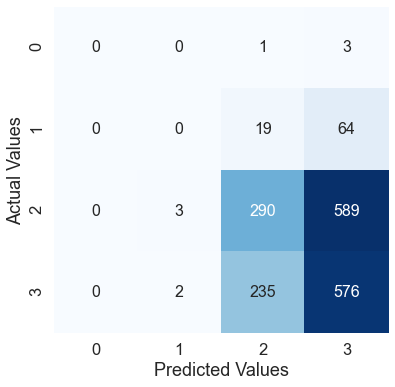

In [23]:
# # ALL features (non-scalled)
# tic = datetime.now()

# compile_train(stackedLSTM_model,X_train,Y_train_cat,X_val,Y_val_cat) 
# time = datetime.now() - tic
# print("Training time:{}".format(time))

# scores = stackedLSTM_model.evaluate(X_test,Y_test_cat)
# print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

# print(evaluate_error(stackedLSTM_model,X_test, Y_test))

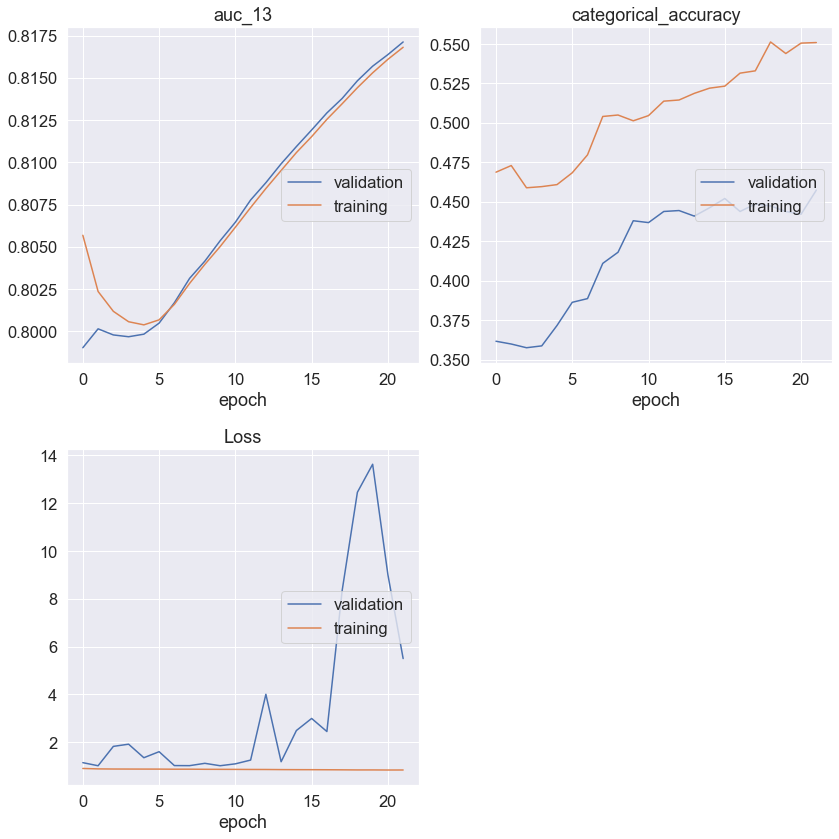

auc_13
	validation       	 (min:    0.799, max:    0.817, cur:    0.817)
	training         	 (min:    0.800, max:    0.817, cur:    0.817)
categorical_accuracy
	validation       	 (min:    0.358, max:    0.457, cur:    0.457)
	training         	 (min:    0.459, max:    0.551, cur:    0.551)
Loss
	validation       	 (min:    1.008, max:   13.633, cur:    5.496)
	training         	 (min:    0.829, max:    0.894, cur:    0.830)
Training time:0:01:06.191050
1782/1782 [==============================] - 0s 94us/step
Accuracy on Test set: 46.80%
|stackedLSTM|
 Error rate = 0.531986531986532 
 MSE =  0.6156004489337823 
 Accuracy =  0.468013468013468 
 AUC =  0.5316509133491858 
 F1-score =  0.23627912278692134 
 Fbeta =  0.2495470608742371
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contro

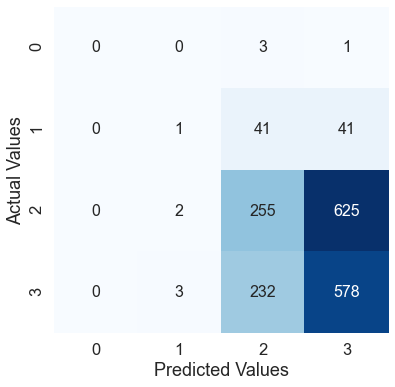

In [24]:
# ALL features (scalled)
tic = datetime.now()

compile_train(stackedLSTM_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(stackedLSTM_model,X_test_scalled,Y_test))

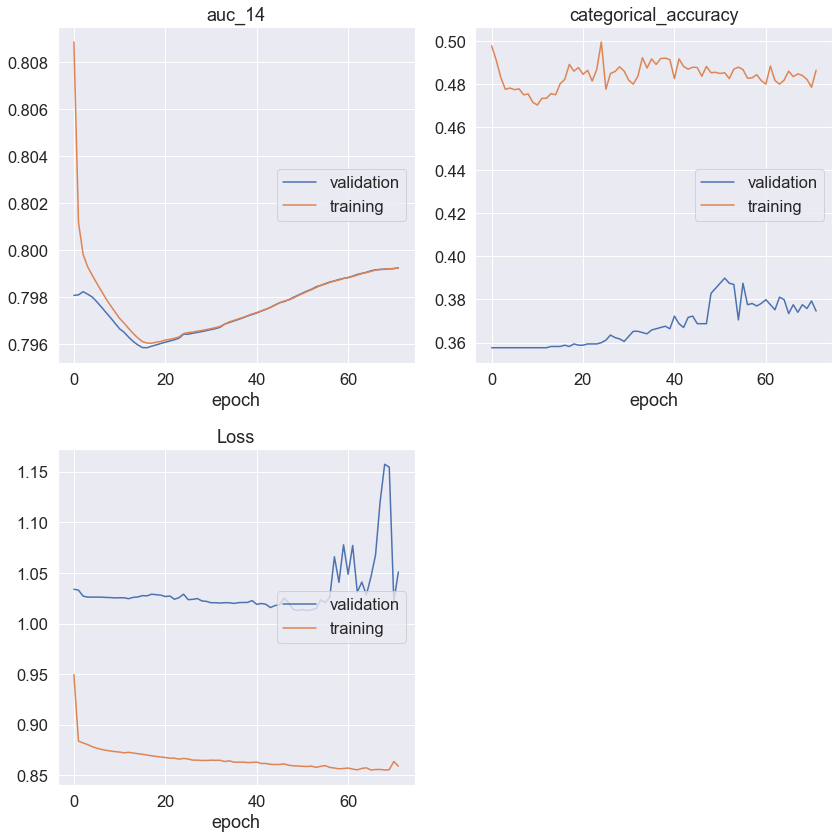

auc_14
	validation       	 (min:    0.796, max:    0.799, cur:    0.799)
	training         	 (min:    0.796, max:    0.809, cur:    0.799)
categorical_accuracy
	validation       	 (min:    0.358, max:    0.390, cur:    0.375)
	training         	 (min:    0.470, max:    0.500, cur:    0.486)
Loss
	validation       	 (min:    1.013, max:    1.157, cur:    1.051)
	training         	 (min:    0.855, max:    0.949, cur:    0.859)
Training time:0:03:04.583807
1782/1782 [==============================] - 0s 92us/step
Accuracy on Test set: 45.45%
|stackedLSTM|
 Error rate = 0.5454545454545454 
 MSE =  0.6790123456790124 
 Accuracy =  0.45454545454545453 
 AUC =  0.5367424505827392 
 F1-score =  0.1830863517026917 
 Fbeta =  0.23553507141147947
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to con

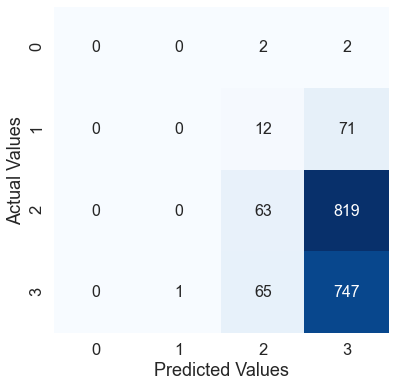

In [25]:
# ALL features (Eye Gaze only)
tic = datetime.now()

compile_train(stackedLSTM_model_feat,X_train_eye,Y_train_cat,X_val_eye,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model_feat.evaluate(X_test_eye,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(stackedLSTM_model_feat,X_test_eye,Y_test))

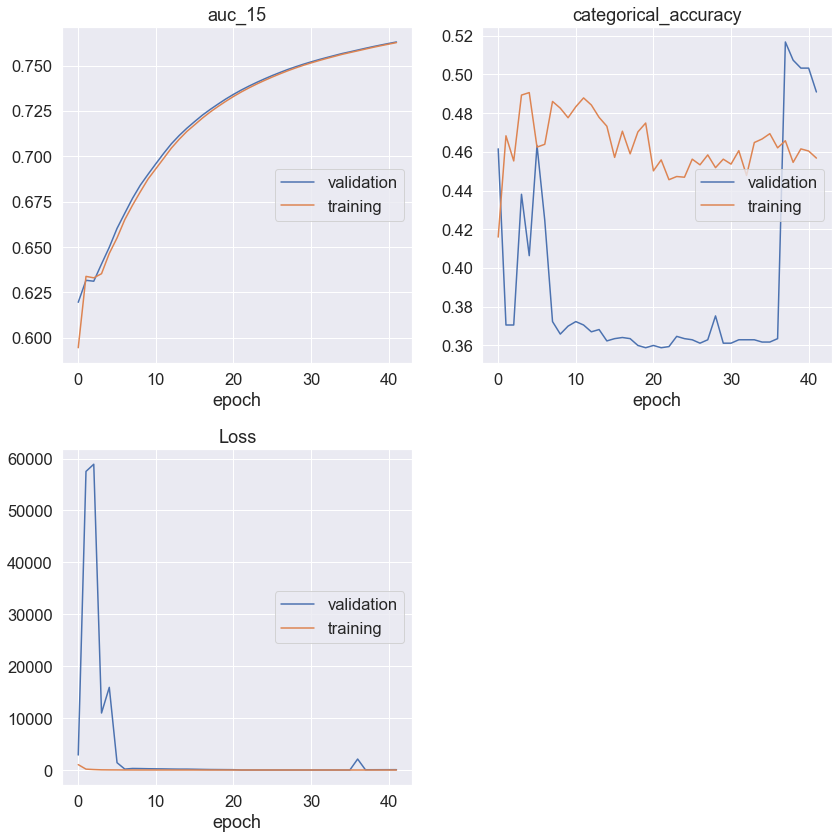

auc_15
	validation       	 (min:    0.620, max:    0.763, cur:    0.763)
	training         	 (min:    0.595, max:    0.763, cur:    0.763)
categorical_accuracy
	validation       	 (min:    0.359, max:    0.517, cur:    0.491)
	training         	 (min:    0.416, max:    0.491, cur:    0.457)
Loss
	validation       	 (min:    1.038, max: 58894.364, cur:   66.796)
	training         	 (min:    0.864, max: 1036.783, cur:    0.865)
Training time:0:02:03.694116
1782/1782 [==============================] - 0s 96us/step
Accuracy on Test set: 48.48%
|stackedLSTM|
 Error rate = 0.5151515151515151 
 MSE =  0.5370370370370371 
 Accuracy =  0.48484848484848486 
 AUC =  0.5206528279746432 
 F1-score =  0.17939768935349157 
 Fbeta =  0.23413824785158482
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

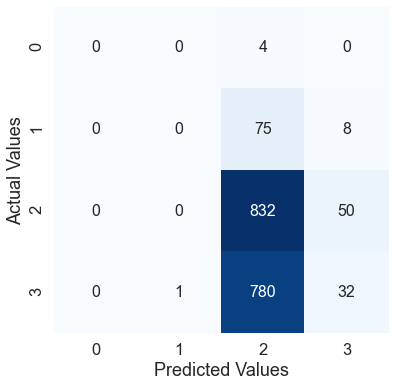

In [26]:
# ALL features (Head Pose only)
tic = datetime.now()

compile_train(stackedLSTM_model_feat,X_train_head,Y_train_cat,X_val_head,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model_feat.evaluate(X_test_head,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(stackedLSTM_model_feat,X_test_head,Y_test))

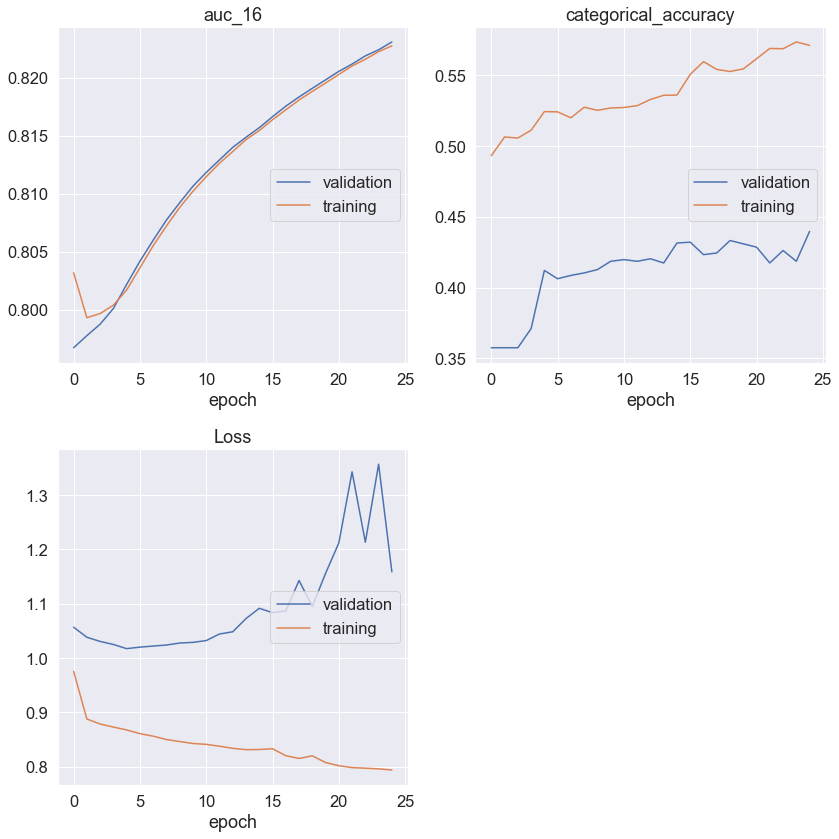

auc_16
	validation       	 (min:    0.797, max:    0.823, cur:    0.823)
	training         	 (min:    0.799, max:    0.823, cur:    0.823)
categorical_accuracy
	validation       	 (min:    0.358, max:    0.440, cur:    0.440)
	training         	 (min:    0.493, max:    0.574, cur:    0.571)
Loss
	validation       	 (min:    1.017, max:    1.357, cur:    1.159)
	training         	 (min:    0.794, max:    0.975, cur:    0.794)
Training time:0:01:05.269697
1782/1782 [==============================] - 0s 93us/step
Accuracy on Test set: 45.74%
|stackedLSTM|
 Error rate = 0.542648709315376 
 MSE =  0.6537598204264871 
 Accuracy =  0.45735129068462405 
 AUC =  0.5028048594436649 
 F1-score =  0.23788557422807483 
 Fbeta =  0.24954484136955574
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to con

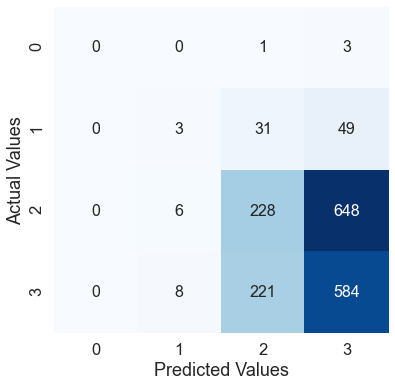

In [27]:
# ALL features (AU only)
tic = datetime.now()

compile_train(stackedLSTM_model_au,X_train_au,Y_train_cat,X_val_au,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model_au.evaluate(X_test_au,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(stackedLSTM_model_au,X_test_au,Y_test))

## 3. biLSTM

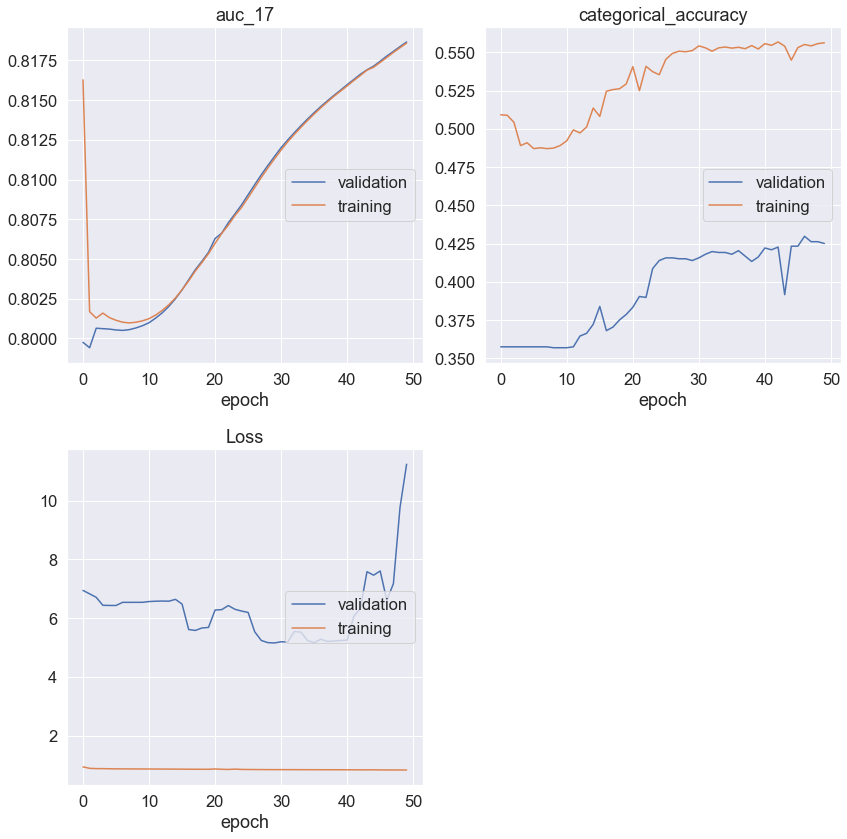

auc_17
	validation       	 (min:    0.799, max:    0.819, cur:    0.819)
	training         	 (min:    0.801, max:    0.819, cur:    0.819)
categorical_accuracy
	validation       	 (min:    0.357, max:    0.430, cur:    0.425)
	training         	 (min:    0.487, max:    0.557, cur:    0.556)
Loss
	validation       	 (min:    5.156, max:   11.236, cur:   11.236)
	training         	 (min:    0.833, max:    0.940, cur:    0.833)
Training time:0:02:02.287915
1782/1782 [==============================] - 0s 101us/step
Accuracy on Test set: 48.26%
|biLSTM|
 Error rate = 0.5173961840628507 
 MSE =  0.6386083052749719 
 Accuracy =  0.4826038159371493 
 AUC =  0.5685212057308482 
 F1-score =  0.2257050726647294 
 Fbeta =  0.2553503268621181
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

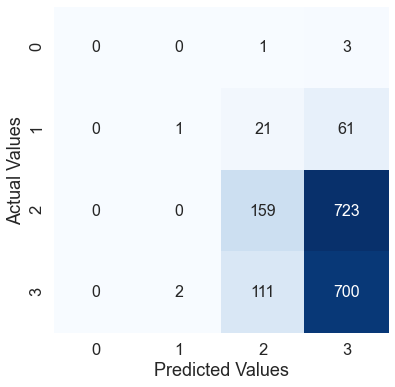

In [28]:
# ALL features  (329 dimensions)
tic = datetime.now()

compile_train(biLSTM_model_all,X_train_all_scalled,Y_train_cat,X_val_all_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model_all.evaluate(X_test_all_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(biLSTM_model_all,X_test_all_scalled, Y_test))

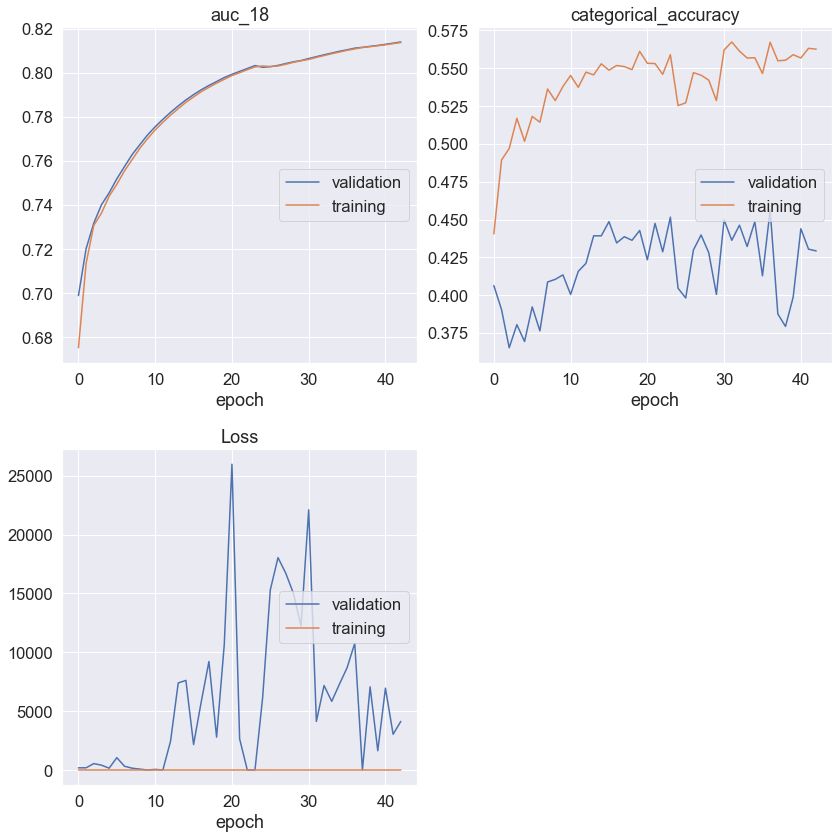

auc_18
	validation       	 (min:    0.699, max:    0.814, cur:    0.814)
	training         	 (min:    0.675, max:    0.814, cur:    0.814)
categorical_accuracy
	validation       	 (min:    0.365, max:    0.456, cur:    0.429)
	training         	 (min:    0.440, max:    0.567, cur:    0.563)
Loss
	validation       	 (min:    1.140, max: 25975.118, cur: 4132.191)
	training         	 (min:    0.807, max:    5.256, cur:    0.812)
Training time:0:01:43.826971
1782/1782 [==============================] - 0s 91us/step
Accuracy on Test set: 48.99%
|biLSTM|
 Error rate = 0.51010101010101 
 MSE =  0.6290684624017957 
 Accuracy =  0.4898989898989899 
 AUC =  0.5016474155113294 
 F1-score =  0.2513304579949332 
 Fbeta =  0.2576831994443585
None


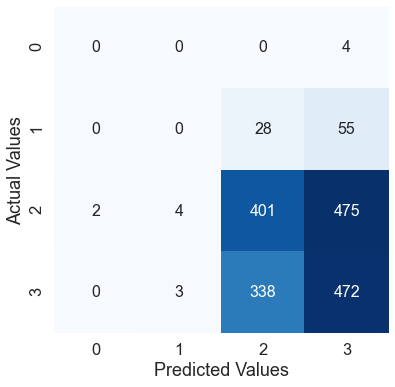

In [29]:
# # ALL features (non-scalled)
# tic = datetime.now()

# compile_train(biLSTM_model,X_train,Y_train_cat,X_val,Y_val_cat) 
# time = datetime.now() - tic
# print("Training time:{}".format(time))

# scores = biLSTM_model.evaluate(X_test,Y_test_cat)
# print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

# print(evaluate_error(biLSTM_model,X_test, Y_test))

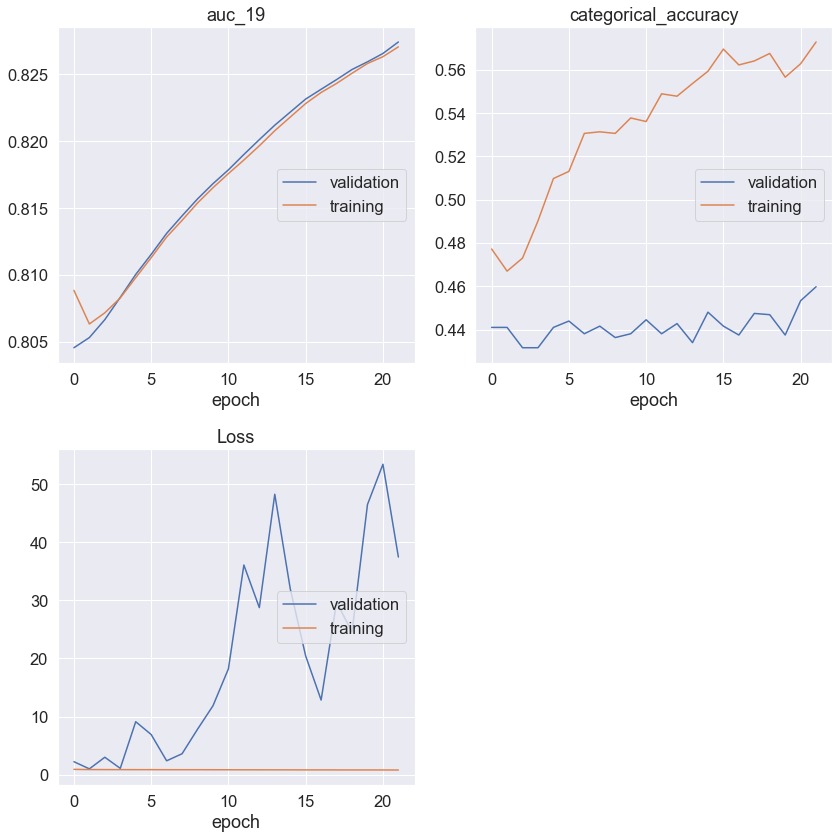

auc_19
	validation       	 (min:    0.805, max:    0.827, cur:    0.827)
	training         	 (min:    0.806, max:    0.827, cur:    0.827)
categorical_accuracy
	validation       	 (min:    0.432, max:    0.460, cur:    0.460)
	training         	 (min:    0.467, max:    0.573, cur:    0.573)
Loss
	validation       	 (min:    0.995, max:   53.429, cur:   37.462)
	training         	 (min:    0.795, max:    0.906, cur:    0.795)
Training time:0:01:01.069715
1782/1782 [==============================] - 0s 94us/step
Accuracy on Test set: 45.62%
|biLSTM|
 Error rate = 0.5437710437710438 
 MSE =  0.6189674523007856 
 Accuracy =  0.4562289562289562 
 AUC =  0.5554362851707721 
 F1-score =  0.24408940406922863 
 Fbeta =  0.24932154141761018
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

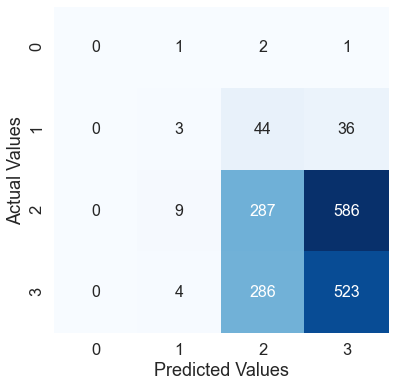

In [30]:
# ALL features (scalled)
tic = datetime.now()

compile_train(biLSTM_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_model,X_test_scalled,Y_test))

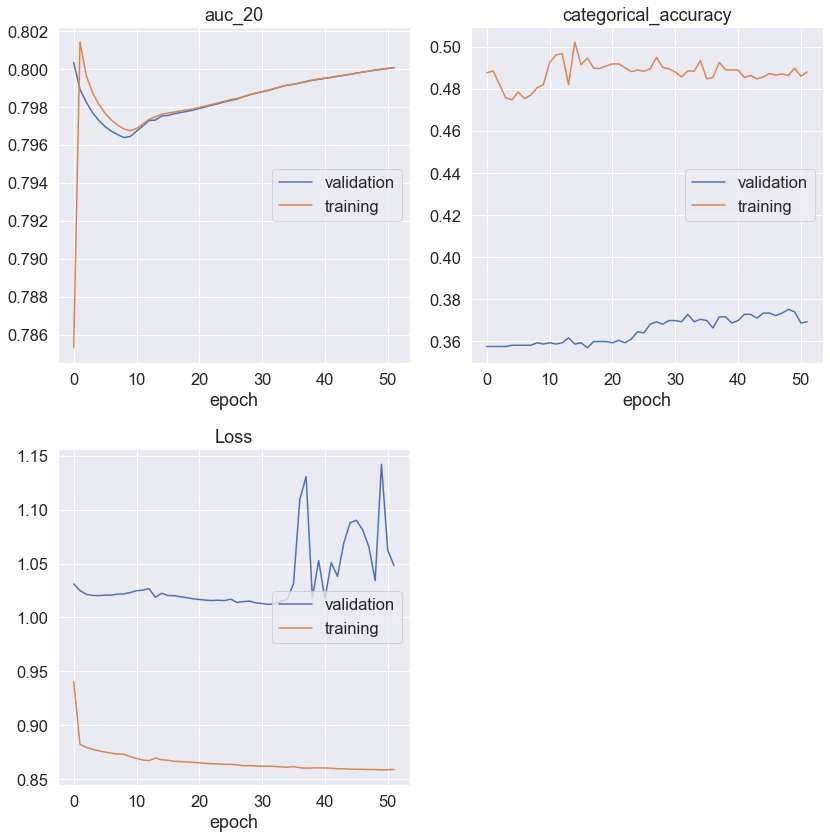

auc_20
	validation       	 (min:    0.796, max:    0.800, cur:    0.800)
	training         	 (min:    0.785, max:    0.801, cur:    0.800)
categorical_accuracy
	validation       	 (min:    0.357, max:    0.375, cur:    0.369)
	training         	 (min:    0.475, max:    0.502, cur:    0.488)
Loss
	validation       	 (min:    1.012, max:    1.142, cur:    1.048)
	training         	 (min:    0.859, max:    0.940, cur:    0.859)
Training time:0:02:06.335640
1782/1782 [==============================] - 0s 92us/step
Accuracy on Test set: 45.17%
|biLSTM|
 Error rate = 0.5482603815937149 
 MSE =  0.6874298540965208 
 Accuracy =  0.45173961840628507 
 AUC =  0.5937475997988271 
 F1-score =  0.1796293076370816 
 Fbeta =  0.23386324746027115
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

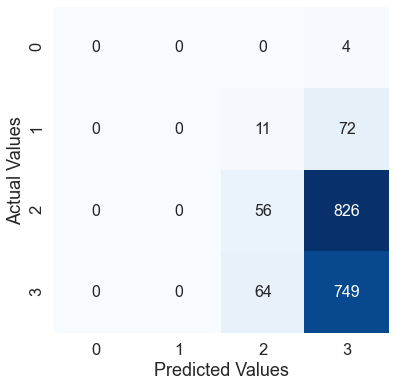

In [31]:
# ALL features (Eye Gaze only)
tic = datetime.now()

compile_train(biLSTM_model_feat,X_train_eye,Y_train_cat,X_val_eye,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model_feat.evaluate(X_test_eye,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_model_feat,X_test_eye,Y_test))

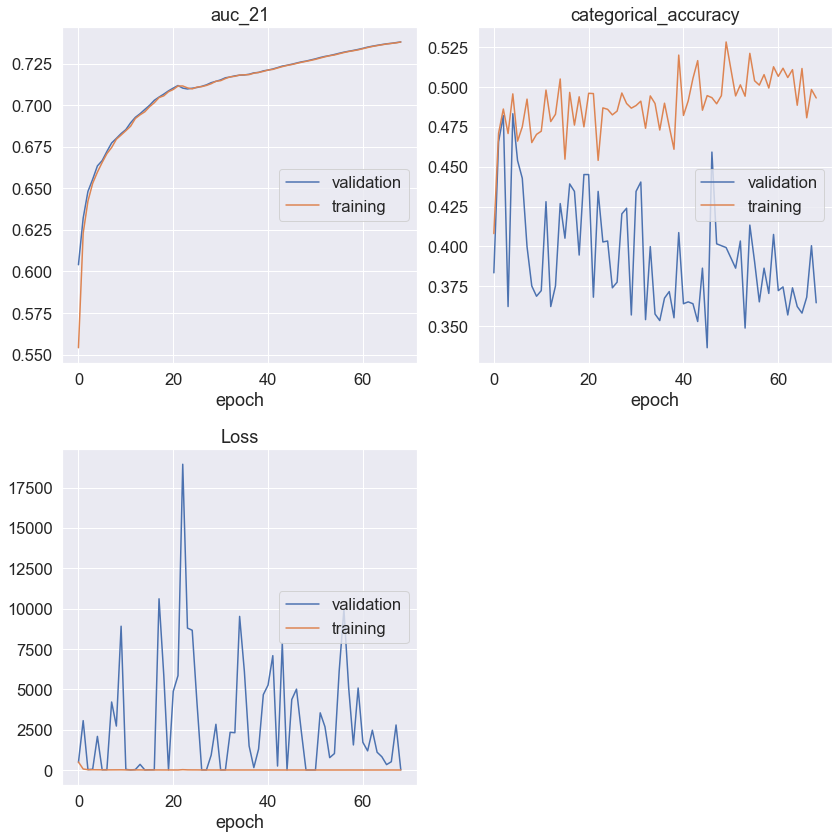

auc_21
	validation       	 (min:    0.604, max:    0.738, cur:    0.738)
	training         	 (min:    0.554, max:    0.738, cur:    0.738)
categorical_accuracy
	validation       	 (min:    0.336, max:    0.483, cur:    0.365)
	training         	 (min:    0.408, max:    0.528, cur:    0.493)
Loss
	validation       	 (min:    1.774, max: 18948.111, cur:    5.291)
	training         	 (min:    1.200, max:  498.961, cur:    1.816)
Training time:0:03:09.432012
1782/1782 [==============================] - 0s 96us/step
Accuracy on Test set: 47.08%
|biLSTM|
 Error rate = 0.5291806958473625 
 MSE =  0.6879910213243546 
 Accuracy =  0.4708193041526375 
 AUC =  0.5169244199574967 
 F1-score =  0.20341148638274933 
 Fbeta =  0.24748494912150526
None


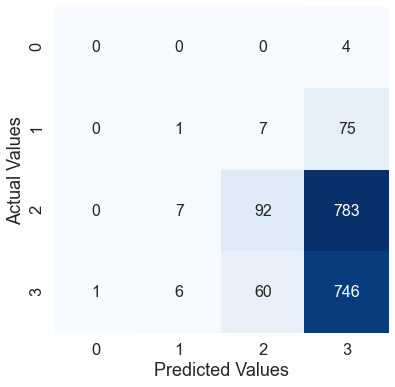

In [32]:
# ALL features (Head Pose only)
tic = datetime.now()

compile_train(biLSTM_model_feat,X_train_head,Y_train_cat,X_val_head,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model_feat.evaluate(X_test_head,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_model_feat,X_test_head,Y_test))

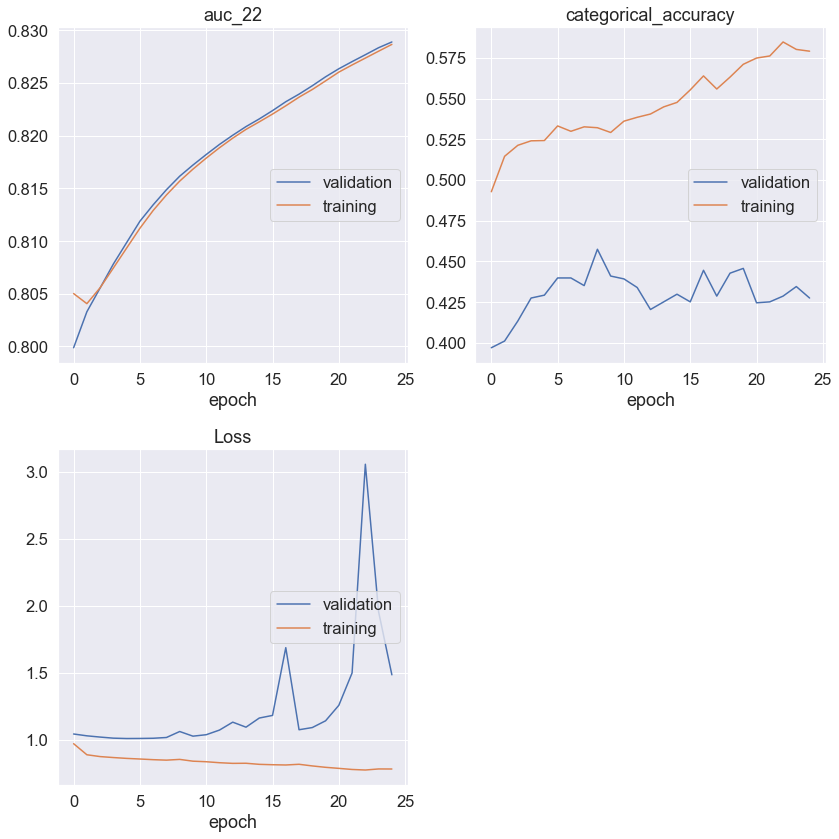

auc_22
	validation       	 (min:    0.800, max:    0.829, cur:    0.829)
	training         	 (min:    0.804, max:    0.829, cur:    0.829)
categorical_accuracy
	validation       	 (min:    0.397, max:    0.457, cur:    0.427)
	training         	 (min:    0.493, max:    0.585, cur:    0.579)
Loss
	validation       	 (min:    1.008, max:    3.057, cur:    1.484)
	training         	 (min:    0.773, max:    0.970, cur:    0.781)
Training time:0:01:00.665945
1782/1782 [==============================] - 0s 102us/step
Accuracy on Test set: 46.46%
|biLSTM|
 Error rate = 0.5353535353535354 
 MSE =  0.6459034792368126 
 Accuracy =  0.46464646464646464 
 AUC =  0.44136903449290493 
 F1-score =  0.24760453774077318 
 Fbeta =  0.2588109736240423
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contro

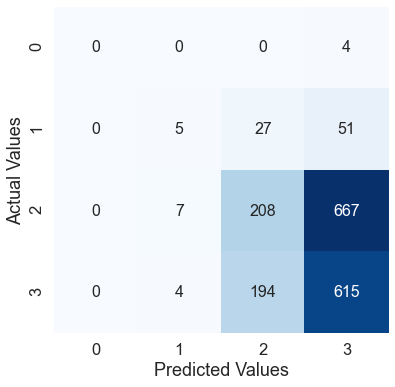

In [33]:
# ALL features (AU only)
tic = datetime.now()

compile_train(biLSTM_model_au,X_train_au,Y_train_cat,X_val_au,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model_au.evaluate(X_test_au,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_model_au,X_test_au,Y_test))

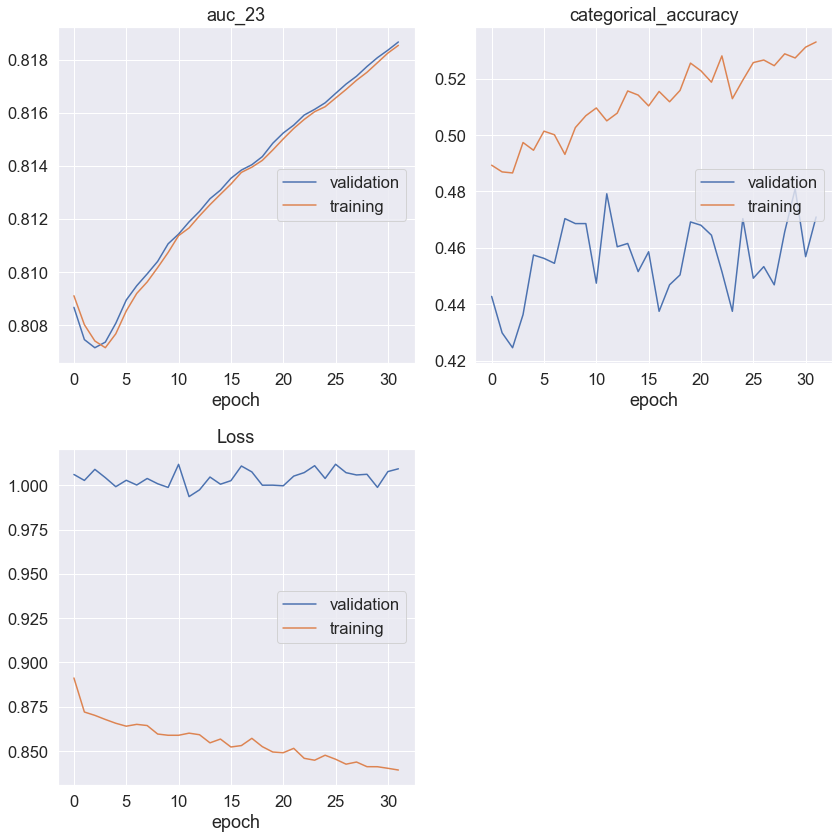

auc_23
	validation       	 (min:    0.807, max:    0.819, cur:    0.819)
	training         	 (min:    0.807, max:    0.819, cur:    0.819)
categorical_accuracy
	validation       	 (min:    0.425, max:    0.481, cur:    0.471)
	training         	 (min:    0.487, max:    0.533, cur:    0.533)
Loss
	validation       	 (min:    0.994, max:    1.012, cur:    1.009)
	training         	 (min:    0.839, max:    0.891, cur:    0.839)
Training time:0:01:42.616293
1782/1782 [==============================] - 0s 105us/step
Accuracy on Test set: 47.03%
|biLSTM_en|
 Error rate = 0.5297418630751964 
 MSE =  0.6139169472502806 
 Accuracy =  0.4702581369248036 
 AUC =  0.5629529794979397 
 F1-score =  0.23132984478667779 
 Fbeta =  0.24775090026442598
None
C:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

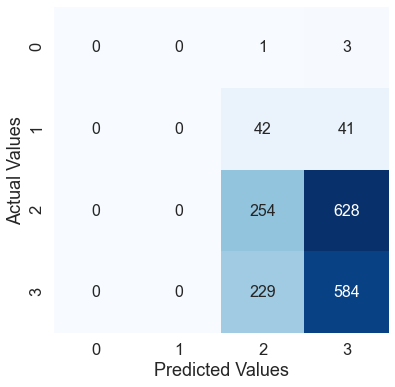

In [34]:
# ALL features (non-scalled)
tic = datetime.now()

compile_train(biLSTM_en_model,X_train,Y_train_cat,X_val,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model.evaluate(X_test,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(biLSTM_en_model,X_test, Y_test))

## TEST ON EmotiW2018  